```
This notebook sets up and runs a set of benchmarks to compare
different numerical discretizations of the SWEs

Copyright (C) 2016  SINTEF ICT

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

## Import modules and set up environment

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt

import os
import pyopencl
import datetime
import sys

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Import our simulator
from SWESimulators import FBL, CTCS,KP07, CDKLM16, PlotHelper, Common
#Import initial condition and bathymetry generating functions:
from SWESimulators.BathymetryAndICs import *

In [2]:
#Make sure we get compiler output from OpenCL
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"

#Set which CL device to use, and disable kernel caching
if (str.lower(sys.platform).startswith("linux")):
    os.environ["PYOPENCL_CTX"] = "0"
else:
    os.environ["PYOPENCL_CTX"] = "1"
os.environ["CUDA_CACHE_DISABLE"] = "1"
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"
os.environ["PYOPENCL_NO_CACHE"] = "1"

#Create OpenCL context
cl_ctx = pyopencl.create_some_context()
print "Using ", cl_ctx.devices[0].name

Using  GeForce 840M


In [3]:
#Create output directory for images
imgdir='images_convergence_' + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
os.makedirs(imgdir)
print "Saving images to " + imgdir

Saving images to images_convergence_2018_06_01-15_02_24


In [4]:
def setBwStyles(ax):
    from cycler import cycler

    ax.set_prop_cycle( cycler('marker', ['.', 'x', 4, '+', '*', '1']) +
                       cycler('linestyle', ['-.', '--', ':', '-.', '--', ':']) +
                       #cycler('markersize', [15, 15, 15, 15, 15, 15]) +
                       cycler('color', ['k', 'k', 'k', 'k', 'k', 'k']) )

In [5]:
def rebin(a, *args):
    '''rebin ndarray data into a smaller ndarray of the same rank whose dimensions
    are factors of the original dimensions. eg. An array with 6 columns and 4 rows
    can be reduced to have 6,3,2 or 1 columns and 4,2 or 1 rows.
    example usages:
    >>> a=rand(6,4); b=rebin(a,3,2)
    >>> a=rand(6); b=rebin(a,2)
    '''
    shape = a.shape
    lenShape = len(shape)
    factor = np.asarray(shape)/np.asarray(args)
    evList = ['a.reshape('] + \
             ['args[%d],factor[%d],'%(i,i) for i in range(lenShape)] + \
             [')'] + ['.sum(%d)'%(i+1) for i in range(lenShape)] + \
             ['/factor[%d]'%i for i in range(lenShape)]
    #print ''.join(evList)
    return eval(''.join(evList))

## Global parameters

In [6]:
width = 512000
height = 512000

domain_sizes = [32, 64, 128, 256]#, 512, 1024, 2048, 4096]
reference_domain_size = 4 * max(domain_sizes)

#schemes = ["FBL"] 
schemes = ["FBL", "CTCS", "KP", "CDKLM"]

#Timestep size    
dt = 8000/reference_domain_size
    
g = 9.81
r = 0.0

# Eddy viscocity parameter
A = 0

# Coriolis parameters: f + beta * y
f = 0.0#8.0e-5

timesteps = 5

end_time = (timesteps - 0.01)*dt
make_netCDF = False

print("Timesteps = " + str(end_time / dt))

Timesteps = 4.99


In [7]:
def initDataBump(h0, eta0, u0, v0, \
            nx, ny, dx, dy, ghosts, \
            g, f):
    
    waterHeight = 60
    x_center = dx*nx/2.0
    y_center = dy*ny/2.0
    size = 0.4*min(nx*dx, ny*dy)
    
    waterHeight = 50 

    def my_exp(i, j):
        x = dx*i - x_center
        y = dy*j - y_center
        return np.exp(-10*(x*x/(size*size)+y*y/(size*size))) * (np.sqrt(x**2 + y**2) < size)
    
    eta0.fill(0.0)
    eta0 += np.fromfunction(lambda i, j: my_exp(i,j), eta0.shape, dtype=np.float32)
    h0.fill(waterHeight)
    u0.fill(0.0)
    v0.fill(0.0)

def initDataBalancedBump(h0, eta0, u0, v0, \
            nx, ny, dx, dy, ghosts, \
            g, f):
    bump_posx = 0.5
    bump_posy = 0.5
    bump_height = 0.25
    bump_width_factor = 20*nx
    waterHeight = 50 
    initializeBalancedBumpOverPoint(eta0, u0, v0, # allocated buffers to be filled with data (output)
                                    nx, ny, dx, dy, ghosts, # grid data
                                    bump_posx, bump_posy, # relative placement of bump center
                                    bump_height, bump_width_factor, # bump information
                                    f, waterHeight, # parameters defined at the bump centre (coriolis force, water depth)
                                    g)
    
    # Scale eta to be out of geostrophic balance
    eta0 *= 1.1
    h0.fill(waterHeight);
    
def initData(h0, eta0, u0, v0, \
            nx, ny, dx, dy, ghosts, \
            g, f):
    initDataBump(h0, eta0, u0, v0, \
            nx, ny, dx, dy, ghosts, \
            g, f)

In [8]:
def plotData(eta0, u0, v0, eta1, u1, v1):
    fig, axarr = plt.subplots(2, 3)
    axarr[0, 0].imshow(eta0, interpolation="nearest")
    axarr[0, 1].imshow(u0, interpolation="nearest")
    axarr[0, 2].imshow(v0, interpolation="nearest")
    axarr[1, 0].imshow(eta1, interpolation="nearest")
    axarr[1, 1].imshow(u1, interpolation="nearest")
    axarr[1, 2].imshow(v1, interpolation="nearest")
    print("Eta0: Maximum = {:.05f}, minimum = {:.05f}".format(np.max(eta0), np.min(eta0)))
    print("Eta1: Maximum = {:.05f}, minimum = {:.05f}".format(np.max(eta1), np.min(eta1)))

## Forward Backward Linear

		t=34.93	Max eta: 0.999696
Eta0: Maximum = 1.00000, minimum = 0.00000
Eta1: Maximum = 0.99970, minimum = 0.00000


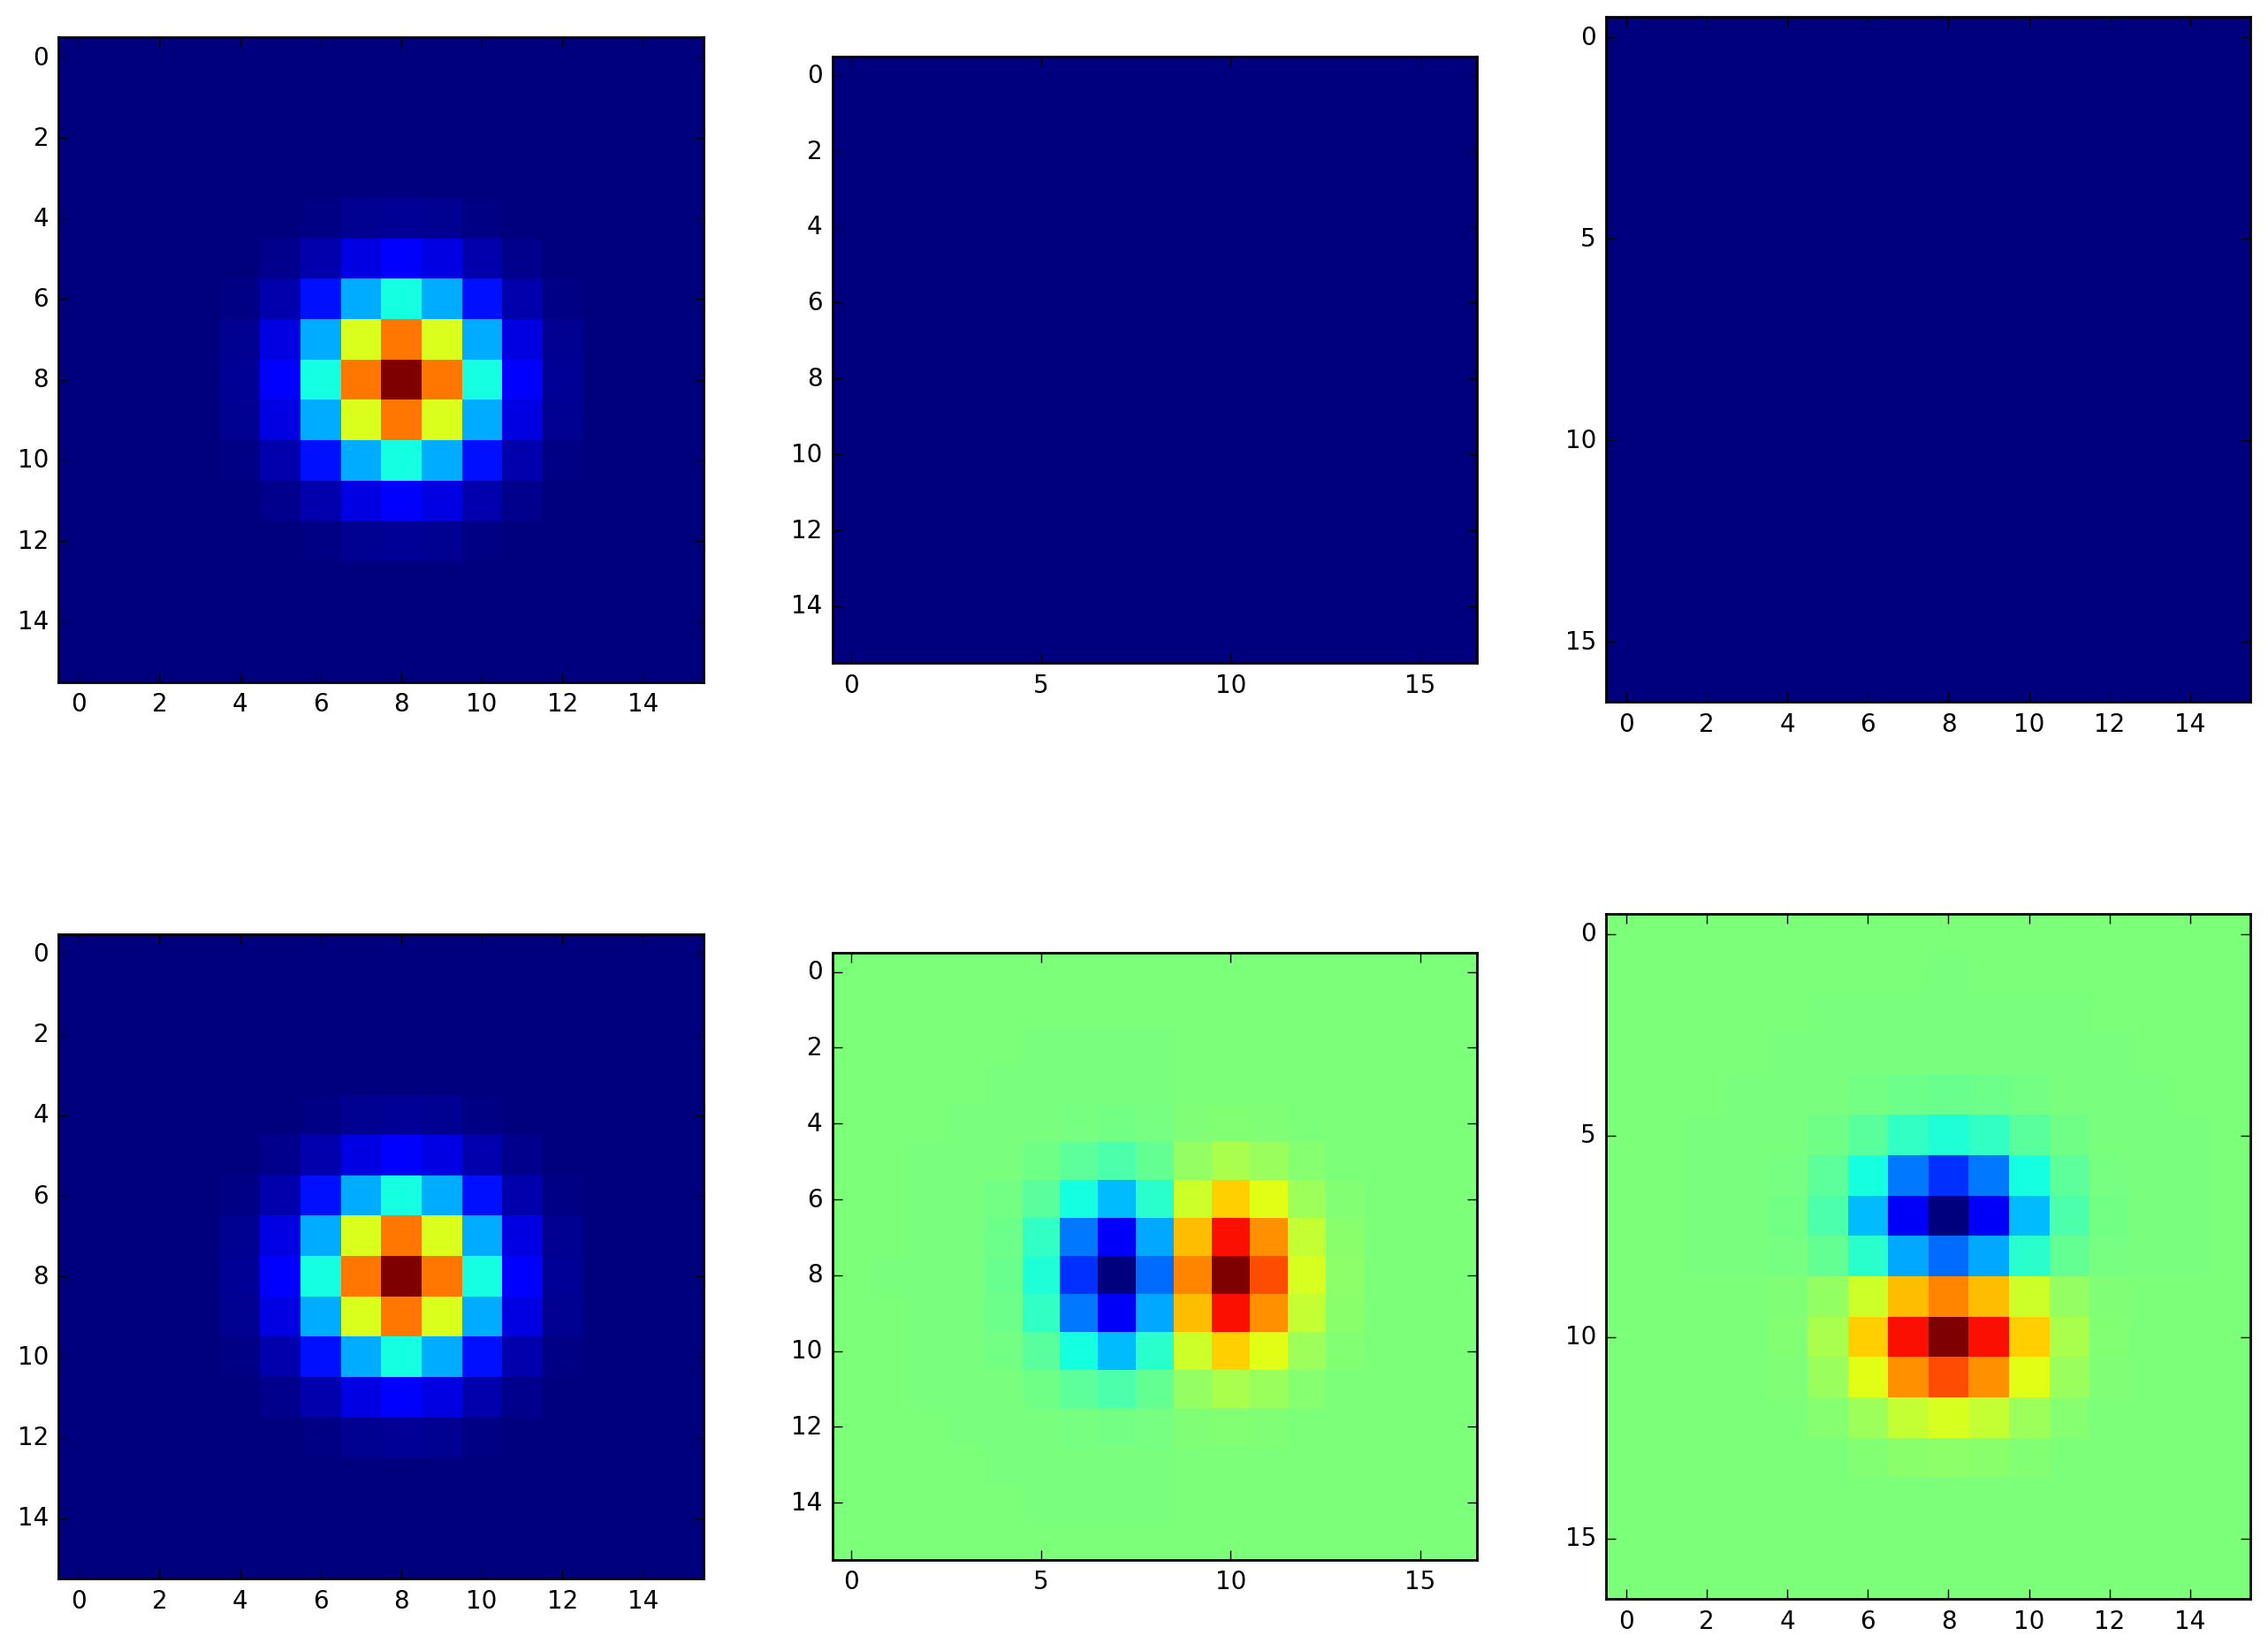

In [9]:
def runFBL(domain_size):
    #Clean up old simulator if any:
    if 'fbl_sim' in globals():
        fbl_sim.cleanUp()
    
    nx = domain_size
    ny = domain_size
    
    dx = float(width/nx)
    dy = float(height/ny)
    
    ghosts = [0, 0, 0, 0] # north, east, south, west
    dataShape = (ny + ghosts[0]+ghosts[2], 
                 nx + ghosts[1]+ghosts[3])

    h0 = np.zeros(dataShape, dtype=np.float32);
    eta0 = np.zeros(dataShape, dtype=np.float32);
    u0 = np.zeros((dataShape[0], dataShape[1]+1), dtype=np.float32);
    v0 = np.zeros((dataShape[0]+1, dataShape[1]), dtype=np.float32);

    # Generate bump in geostrophic balance
    initData(h0, eta0, u0, v0, \
            nx, ny, dx, dy, ghosts, \
            g, f)

    #Initialize simulator
    reload(FBL)
    fbl_sim = FBL.FBL(cl_ctx, \
                  h0, eta0, u0, v0, \
                  nx, ny, \
                  dx, dy, dt, \
                  g, f, r, \
                  write_netcdf=make_netCDF)

    t = fbl_sim.step(end_time)
    eta1, u1, v1 = fbl_sim.download()
    print "\t\tt=" + str(t) +  "\tMax eta: " + str(np.max(eta1))
    
    return [eta0, u0, v0, eta1, u1, v1]

[eta0, u0, v0, eta1, u1, v1] = runFBL(16)
plotData(eta0, u0, v0, eta1, u1, v1)

In [10]:
if make_netCDF:
    fbl_sim.cleanUp()

## Centered in time, centered in space

		t=34.93	Max eta: 0.999747
Eta0: Maximum = 1.00000, minimum = 0.00000
Eta1: Maximum = 0.99975, minimum = -0.00000


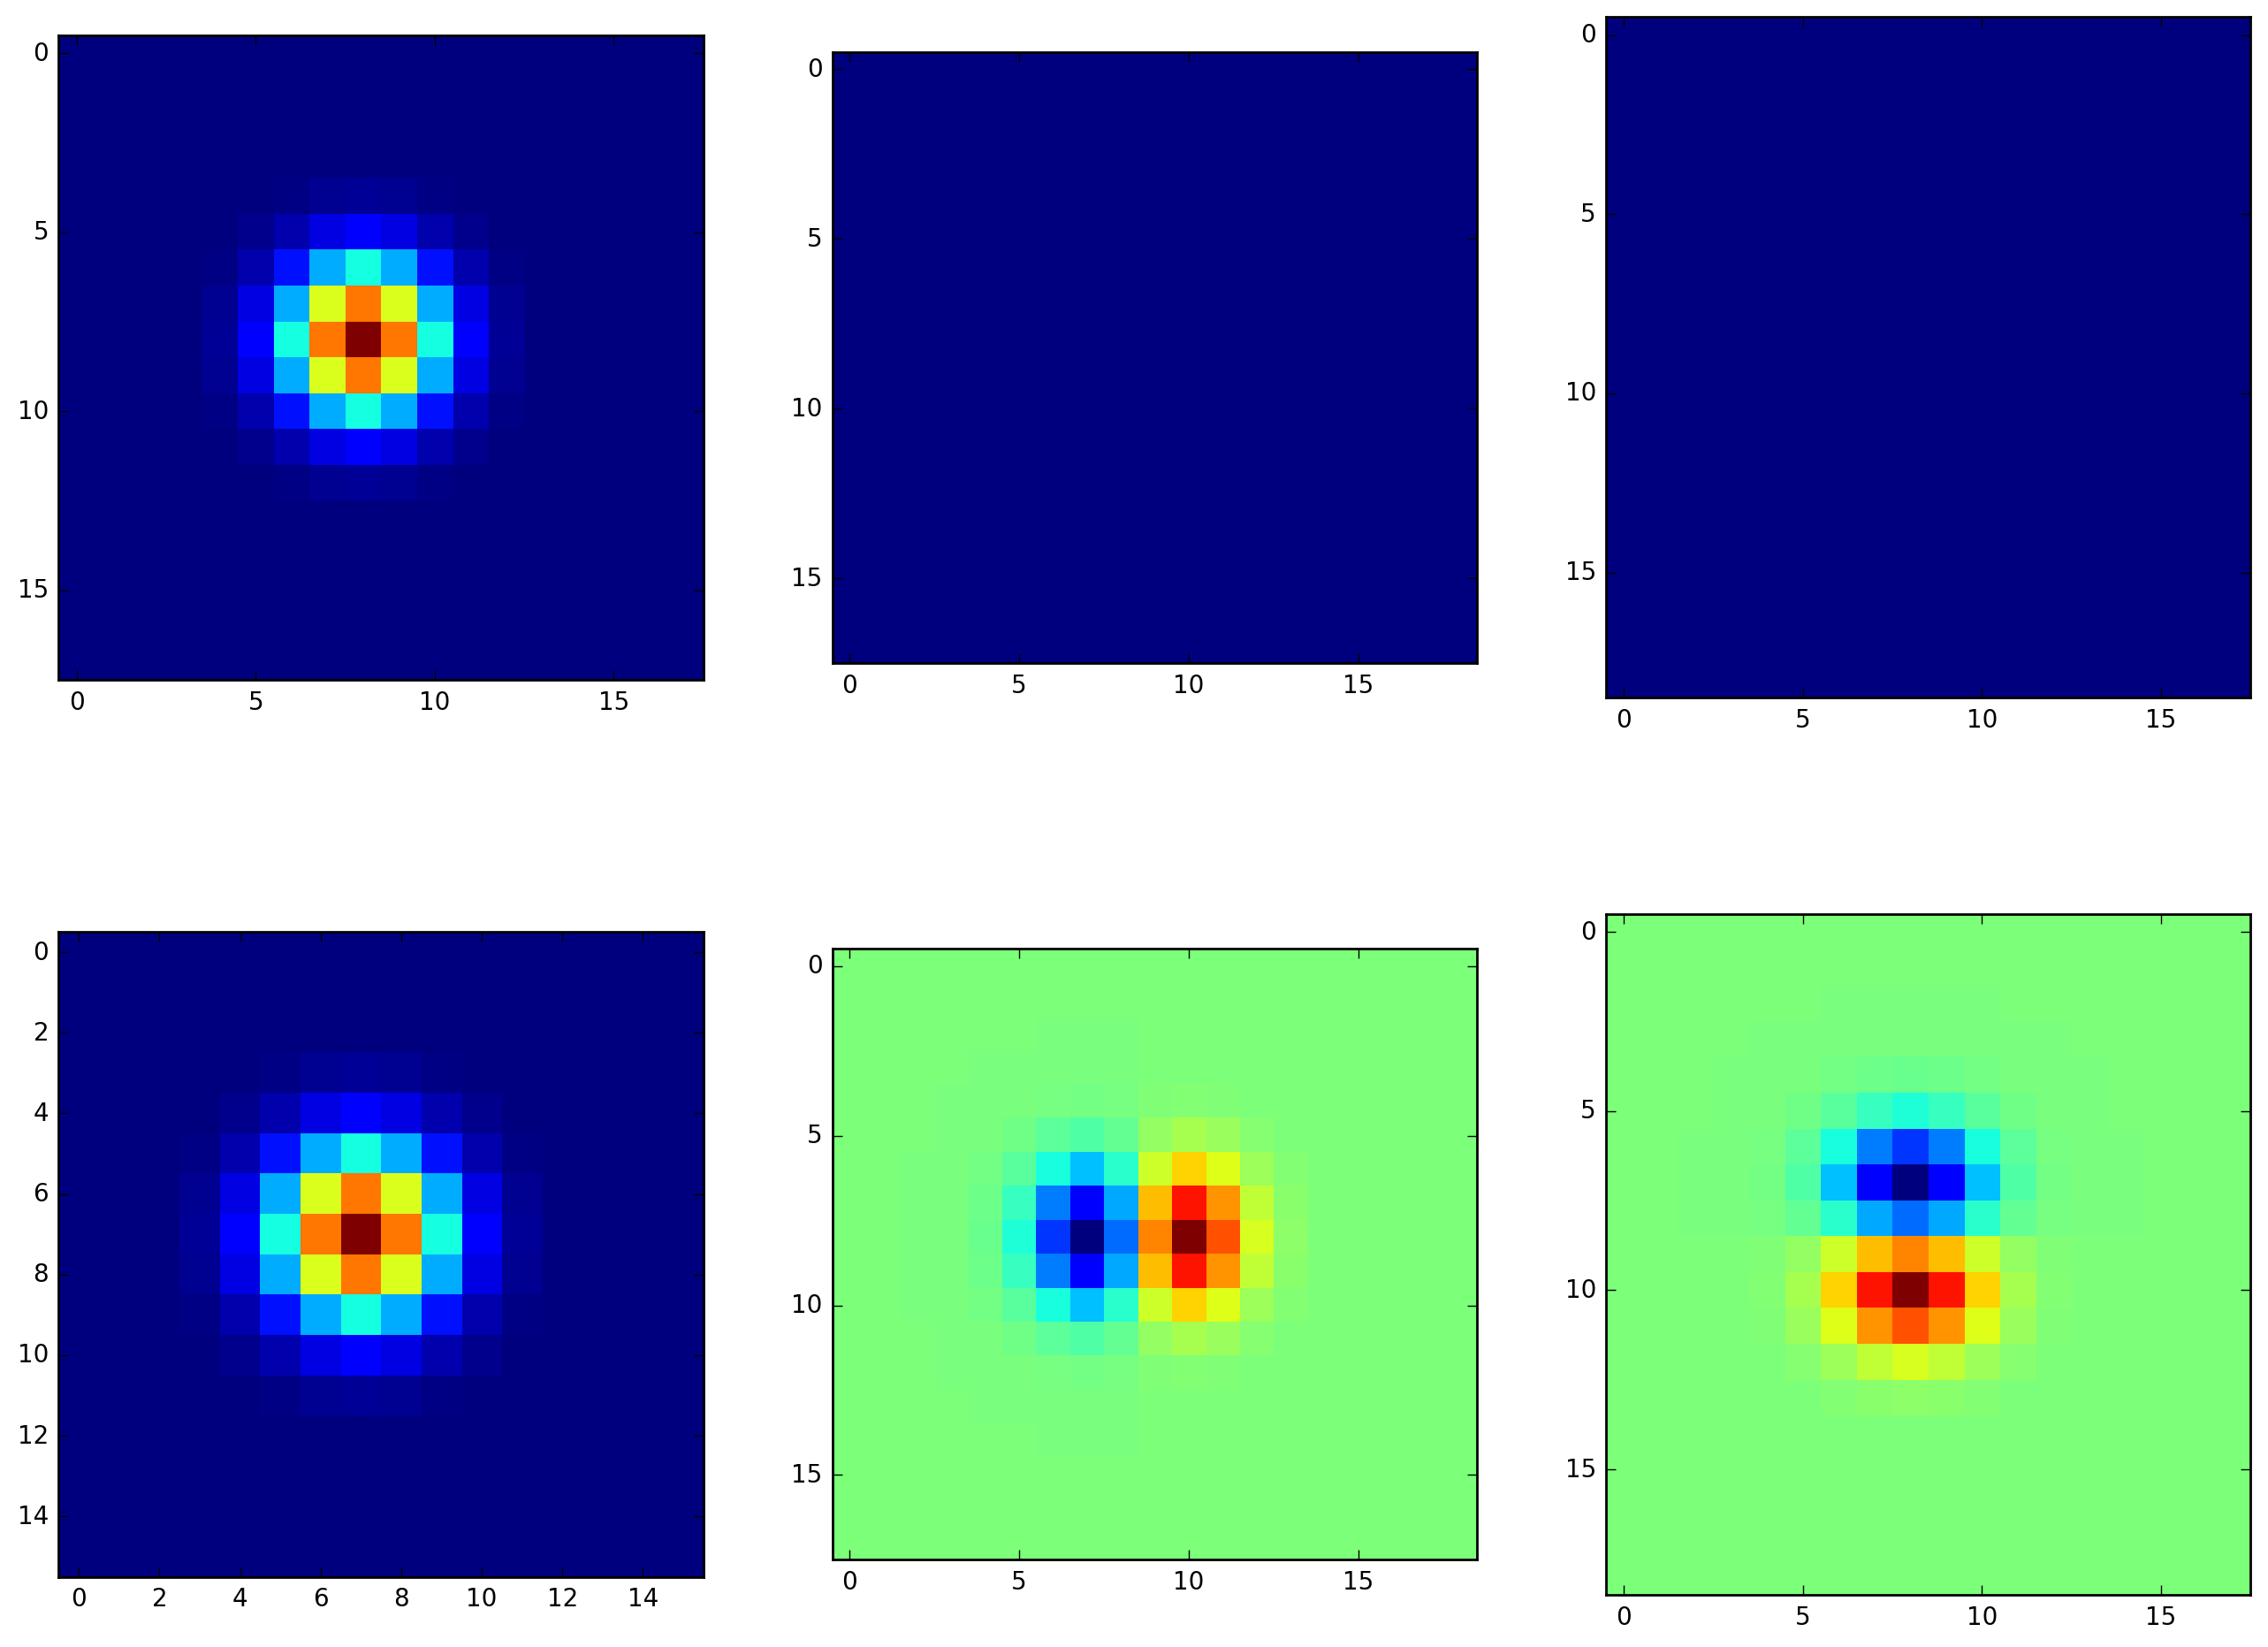

In [11]:
#Centered in time, centered in space

def runCTCS(domain_size):
    #Clean up old simulator if any:
    if 'ctcs_sim' in globals():
        ctcs_sim.cleanUp()
    
    nx = domain_size
    ny = domain_size
    
    dx = float(width/nx)
    dy = float(height/ny)
    
    ghosts = [1,1,1,1] # north, east, south, west
    validDomain = np.array([1,1,1,1])
    dataShape = (ny + ghosts[0]+ghosts[2], 
                 nx + ghosts[1]+ghosts[3])

    h0 = np.zeros(dataShape, dtype=np.float32);
    eta0 = np.zeros(dataShape, dtype=np.float32);
    u0 = np.zeros((dataShape[0], dataShape[1]+1), dtype=np.float32);
    v0 = np.zeros((dataShape[0]+1, dataShape[1]), dtype=np.float32);    

    initData(h0, eta0, u0, v0, \
            nx, ny, dx, dy, ghosts, \
            g, f)
    
    reload(CTCS)
    ctcs_sim = CTCS.CTCS(cl_ctx, \
                         h0, eta0, u0, v0, \
                         nx, ny, dx, dy, dt, \
                         g, f, r, A, \
                         write_netcdf=make_netCDF)

    t = ctcs_sim.step(end_time)
    eta1, u1, v1 = ctcs_sim.download()
    
    # Remove ghost cells
    eta1 = eta1[validDomain[3]:-validDomain[1], validDomain[2]:-validDomain[0]]
    
    print "\t\tt=" + str(t) +  "\tMax eta: " + str(np.max(eta1))
    
    return [eta0, u0, v0, eta1, u1, v1]

[eta0, u0, v0, eta1, u1, v1] = runCTCS(16)
plotData(eta0, u0, v0, eta1, u1, v1)

In [12]:
if make_netCDF:
    ctcs_sim.cleanUp()

## CDKLM 16

		t=34.93	Max eta: 0.996002
Eta0: Maximum = 1.00000, minimum = 0.00000
Eta1: Maximum = 0.99600, minimum = 0.00000


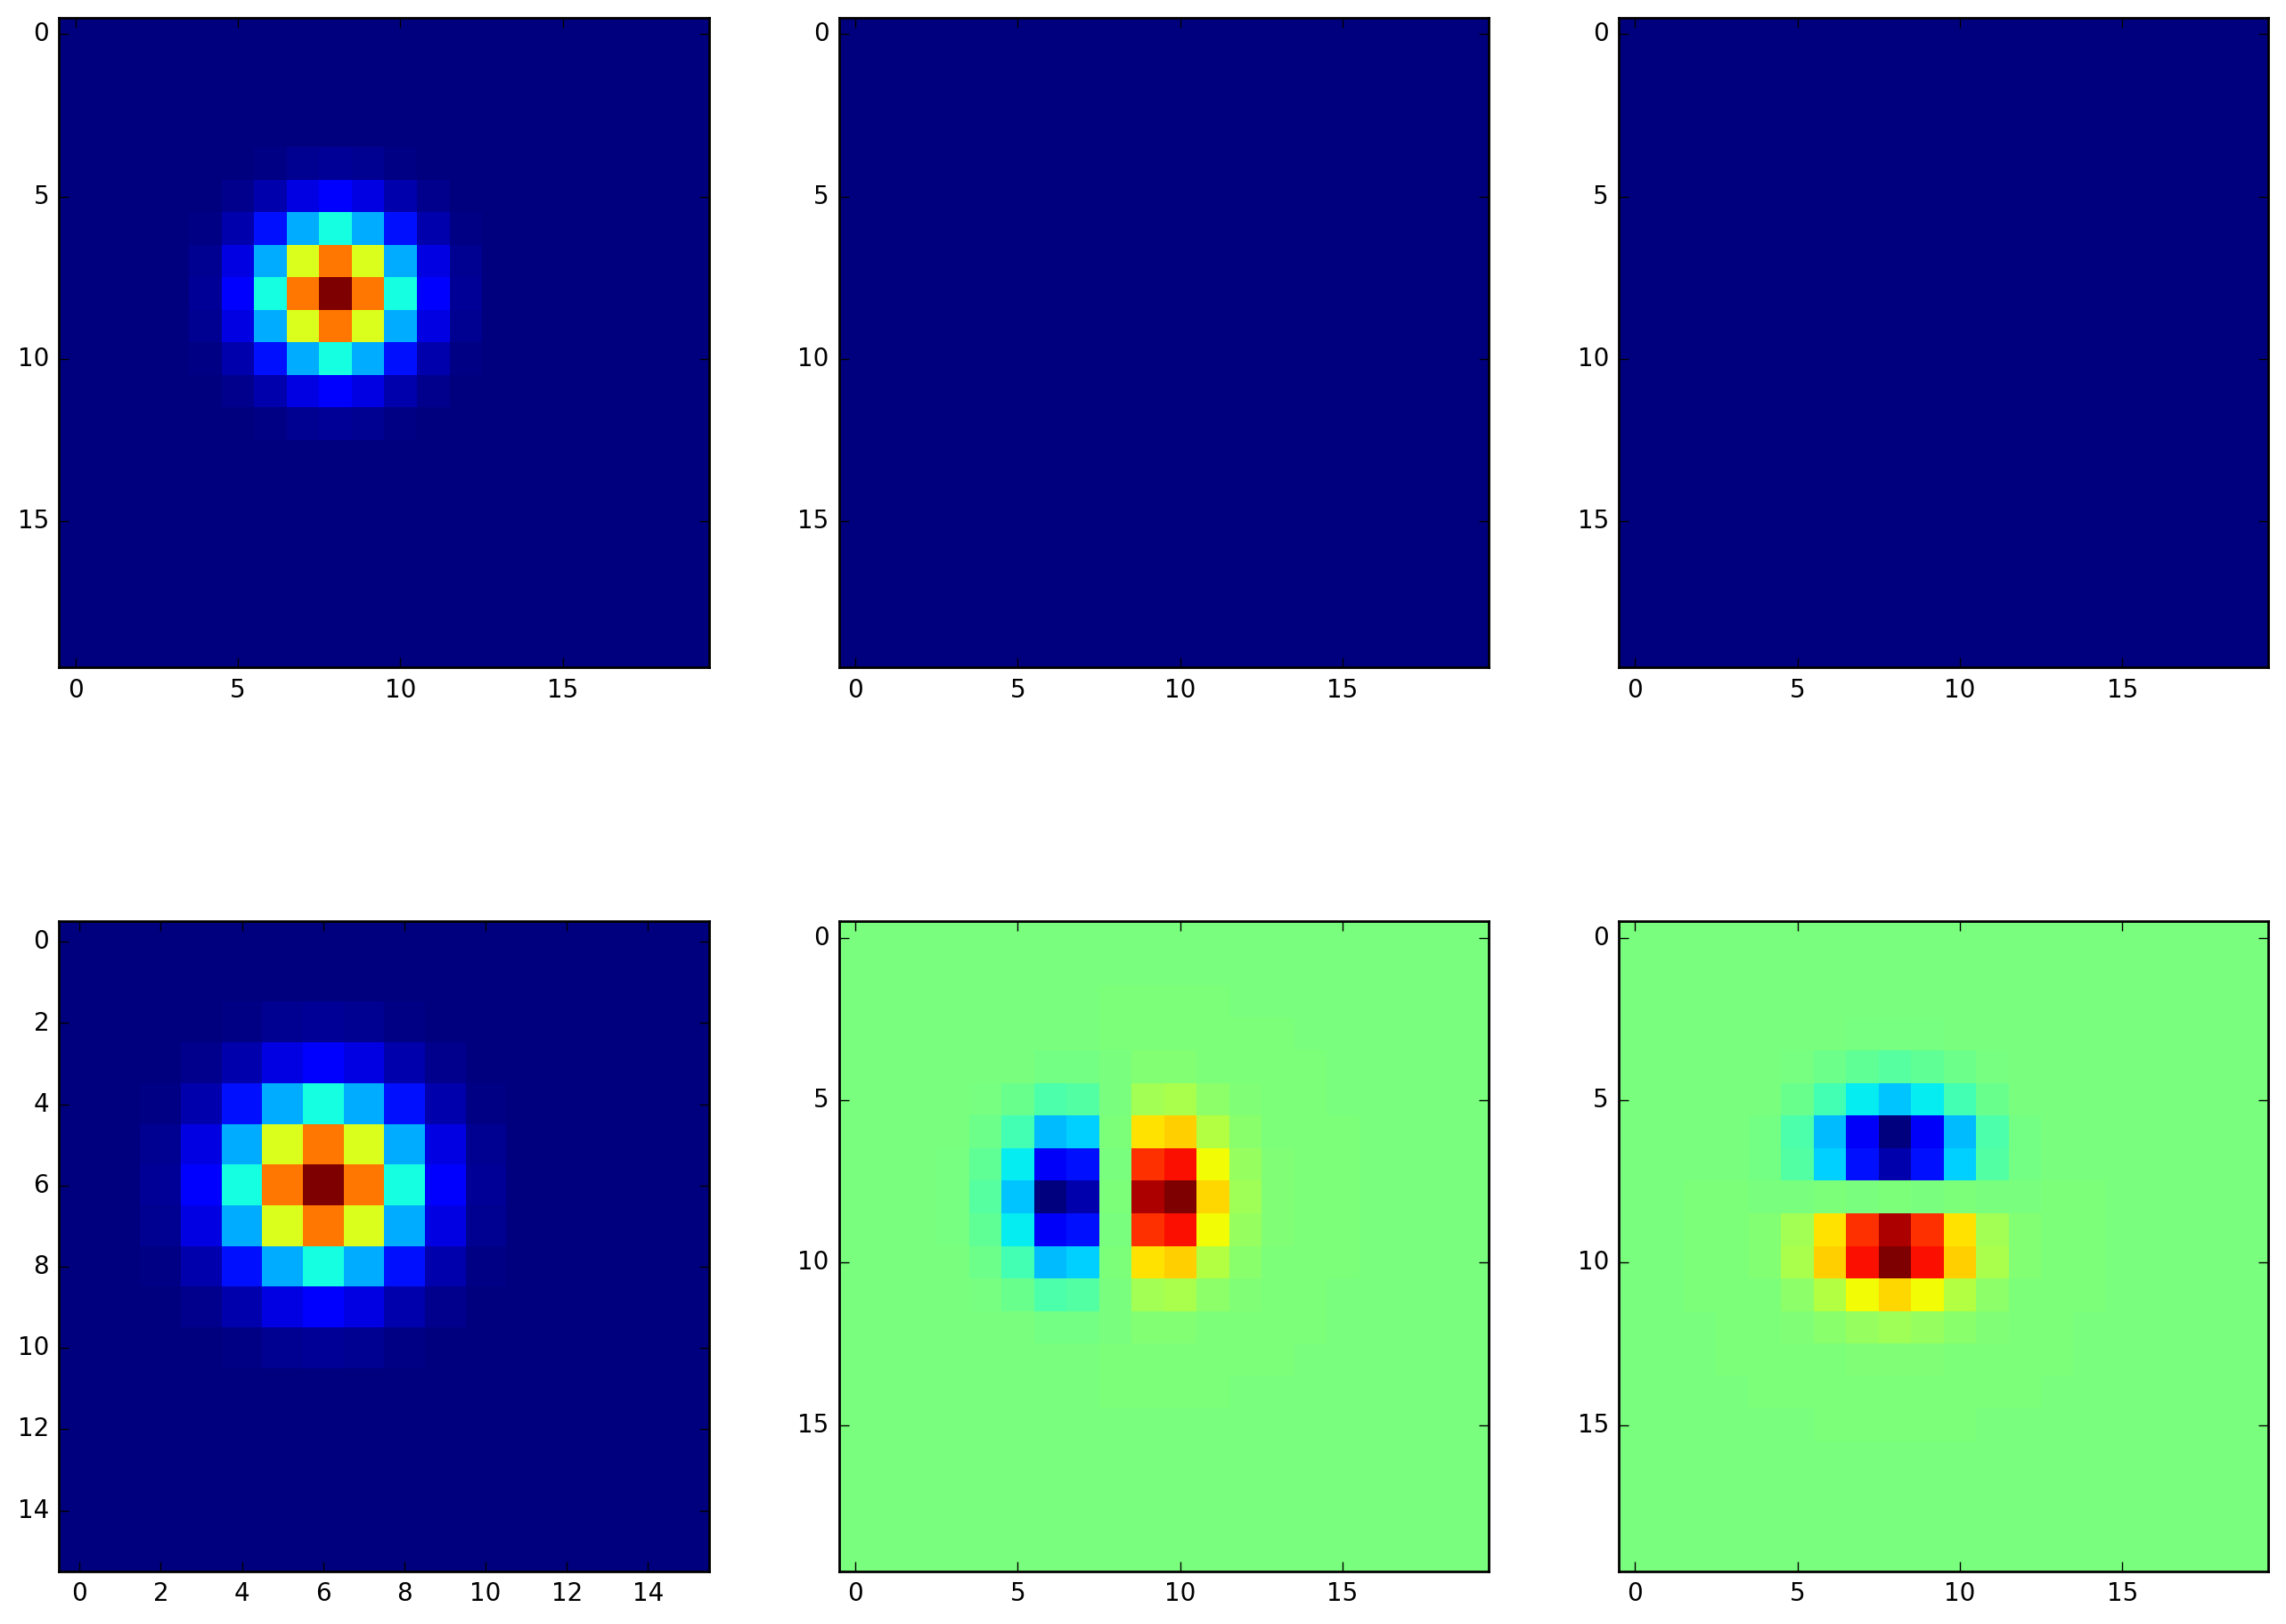

In [13]:
def runCDKLM(domain_size):
    #Clean up old simulator if any:
    if 'cdklm_sim' in globals():
        cdklm_sim.cleanUp()

    #Coriolis well balanced reconstruction scheme
    
    nx = domain_size
    ny = domain_size
    
    dx = float(width/nx)
    dy = float(height/ny)

    ghosts = np.array([2,2,2,2]) # north, east, south, west
    validDomain = np.array([2,2,2,2])
    dataShape = (ny + ghosts[0]+ghosts[2], 
                 nx + ghosts[1]+ghosts[3])

    Hi = np.zeros((dataShape[0]+1, dataShape[1]+1), dtype=np.float32)
    eta0 = np.zeros(dataShape, dtype=np.float32)
    u0   = np.zeros(dataShape, dtype=np.float32)
    v0   = np.zeros(dataShape, dtype=np.float32)

    initData(Hi, eta0, u0, v0, \
            nx, ny, dx, dy, ghosts, \
            g, f)

    #Initialize simulator
    reload(CDKLM16)
    cdklm_sim = CDKLM16.CDKLM16(cl_ctx, \
                                eta0, u0, v0, Hi, \
                                nx, ny, dx, dy, dt, \
                                g, f, r, \
                                rk_order=2, 
                                write_netcdf=make_netCDF)


    t = cdklm_sim.step(end_time)
    eta1, u1, v1 = cdklm_sim.download()
    
    # Remove ghost cells
    eta1 = eta1[validDomain[3]:-validDomain[1], validDomain[2]:-validDomain[0]]
    
    print "\t\tt=" + str(t) +  "\tMax eta: " + str(np.max(eta1))
    
    return [eta0, u0, v0, eta1, u1, v1]

[eta0, u0, v0, eta1, u1, v1] = runCDKLM(16)
plotData(eta0, u0, v0, eta1, u1, v1)

In [14]:
if make_netCDF:
     cdklm_sim.cleanUp()

## Kurganov-Petrova 2007

		t=34.93	Max eta: 0.996002
Eta0: Maximum = 1.00000, minimum = 0.00000
Eta1: Maximum = 0.99600, minimum = 0.00000


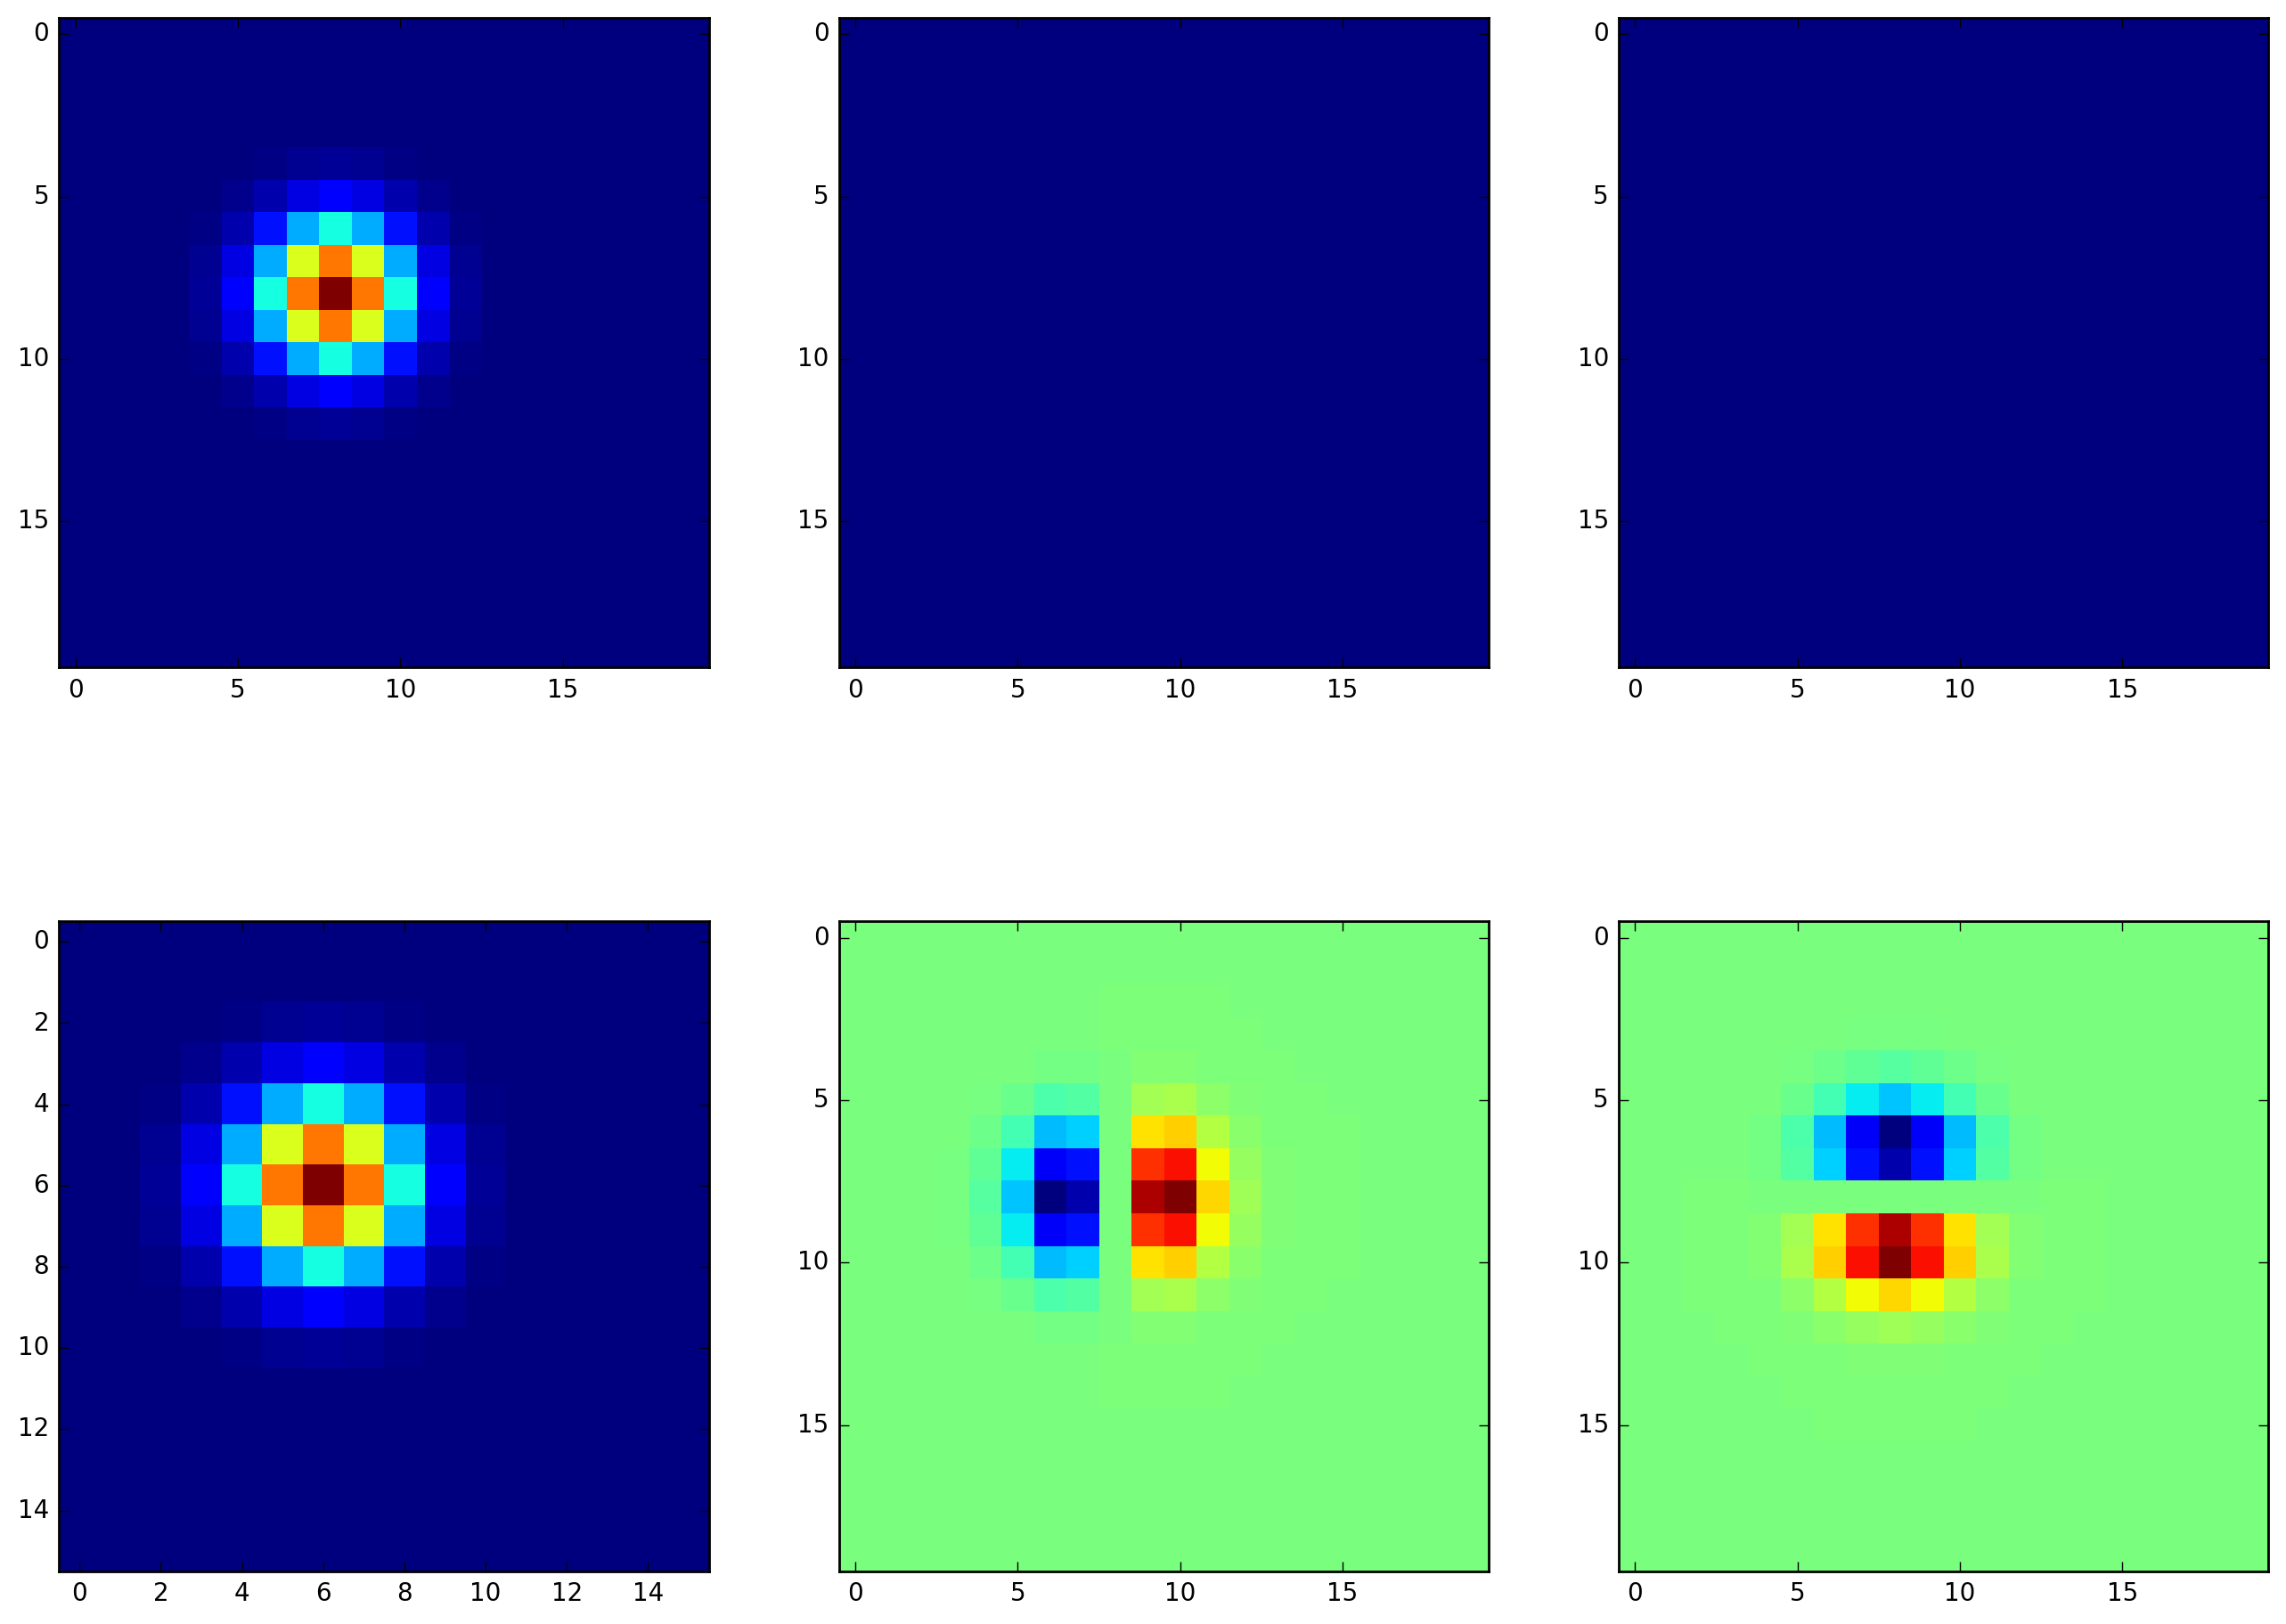

In [15]:
def runKP(domain_size):
    #Clean up old simulator if any:
    if 'kp07_sim' in globals():
        kp07_sim.cleanUp()
    
    # Kurganov-Petrova 2007
    
    nx = domain_size
    ny = domain_size
    
    dx = float(width/nx)
    dy = float(height/ny)
    
    ghosts = np.array([2,2,2,2]) # north, east, south, west
    validDomain = np.array([2,2,2,2])
    dataShape = (ny + ghosts[0]+ghosts[2], 
                 nx + ghosts[1]+ghosts[3])

    Hi = np.zeros((dataShape[0]+1, dataShape[1]+1), dtype=np.float32)
    eta0 = np.zeros(dataShape, dtype=np.float32)
    u0 =   np.zeros(dataShape, dtype=np.float32)
    v0 =   np.zeros(dataShape, dtype=np.float32)

    initData(Hi, eta0, u0, v0, \
            nx, ny, dx, dy, ghosts, \
            g, f)

    #Initialize simulator
    reload(KP07)
    kp07_sim = KP07.KP07(cl_ctx, \
                         eta0, Hi, u0, v0, \
                         nx, ny, dx, dy, dt, \
                         g, f, r, \
                         write_netcdf=make_netCDF,\
                         use_rk2=True)

    t = kp07_sim.step(end_time)
    eta1, u1, v1 = kp07_sim.download()
    
    # Remove ghost cells
    eta1 = eta1[validDomain[3]:-validDomain[1], validDomain[2]:-validDomain[0]]
    
    print "\t\tt=" + str(t) +  "\tMax eta: " + str(np.max(eta1))
    
    return [eta0, u0, v0, eta1, u1, v1]

[eta0, u0, v0, eta1, u1, v1] = runKP(16)
plotData(eta0, u0, v0, eta1, u1, v1)

In [16]:
if make_netCDF:
    kp07_sim.cleanUp()

## Control 

In [17]:
for scheme in schemes:
    print "Scheme: " + scheme
    
    data = {};
    
    # Make reference solution
    print "\tDomain size (reference solution): " + str(reference_domain_size)
    [_, _, _, eta1_ref, _, _] = eval("run" + scheme + "(" + str(reference_domain_size) + ")")
    
    data[str(reference_domain_size)] = eta1_ref

    # Run all domain sizes
    for domain_size in domain_sizes:
        print "\tDomain size: " + str(domain_size)
        [_, _, _, eta1, _, _] = eval("run" + scheme + "(" + str(domain_size) + ")")
        
        data[str(domain_size)] = eta1
        
    
    out_filename = imgdir + "/" + scheme + "_data.npz"
    np.savez(out_filename, **data)

Scheme: FBL
	Domain size (reference solution): 1024
		t=34.93	Max eta: 0.999658
	Domain size: 32
		t=34.93	Max eta: 0.999668
	Domain size: 64
		t=34.93	Max eta: 0.99966
	Domain size: 128
		t=34.93	Max eta: 0.999658
	Domain size: 256
		t=34.93	Max eta: 0.999658
Scheme: CTCS
	Domain size (reference solution): 1024
		t=34.93	Max eta: 0.999714
	Domain size: 32
		t=34.93	Max eta: 0.999723
	Domain size: 64
		t=34.93	Max eta: 0.999716
	Domain size: 128
		t=34.93	Max eta: 0.999715
	Domain size: 256
		t=34.93	Max eta: 0.999714
Scheme: KP
	Domain size (reference solution): 1024
		t=34.93	Max eta: 0.999708
	Domain size: 32
		t=34.93	Max eta: 0.997749
	Domain size: 64
		t=34.93	Max eta: 0.998763
	Domain size: 128
		t=34.93	Max eta: 0.999279
	Domain size: 256
		t=34.93	Max eta: 0.999536
Scheme: CDKLM
	Domain size (reference solution): 1024
		t=34.93	Max eta: 0.999706
	Domain size: 32
		t=34.93	Max eta: 0.997749
	Domain size: 64
		t=34.93	Max eta: 0.998763
	Domain size: 128
		t=34.93	Max eta: 0.9992

Scheme: FBL
Scheme: CTCS
Scheme: KP
Scheme: CDKLM
Scheme FBL
	Domain size: 32: 10902.4805844
	Domain size: 64: 5318.16157221
	Domain size: 128: 2511.62969018
	Domain size: 256: 1104.46983462
Scheme CTCS
	Domain size: 32: 10902.7995121
	Domain size: 64: 5318.31819179
	Domain size: 128: 2511.702873
	Domain size: 256: 1104.50466839
Scheme KP
	Domain size: 32: 29796.8142109
	Domain size: 64: 14680.9458335
	Domain size: 128: 6889.68327192
	Domain size: 256: 2965.72385068
Scheme CDKLM
	Domain size: 32: 29796.8133596
	Domain size: 64: 14680.9460607
	Domain size: 128: 6889.6839957
	Domain size: 256: 2965.72436714


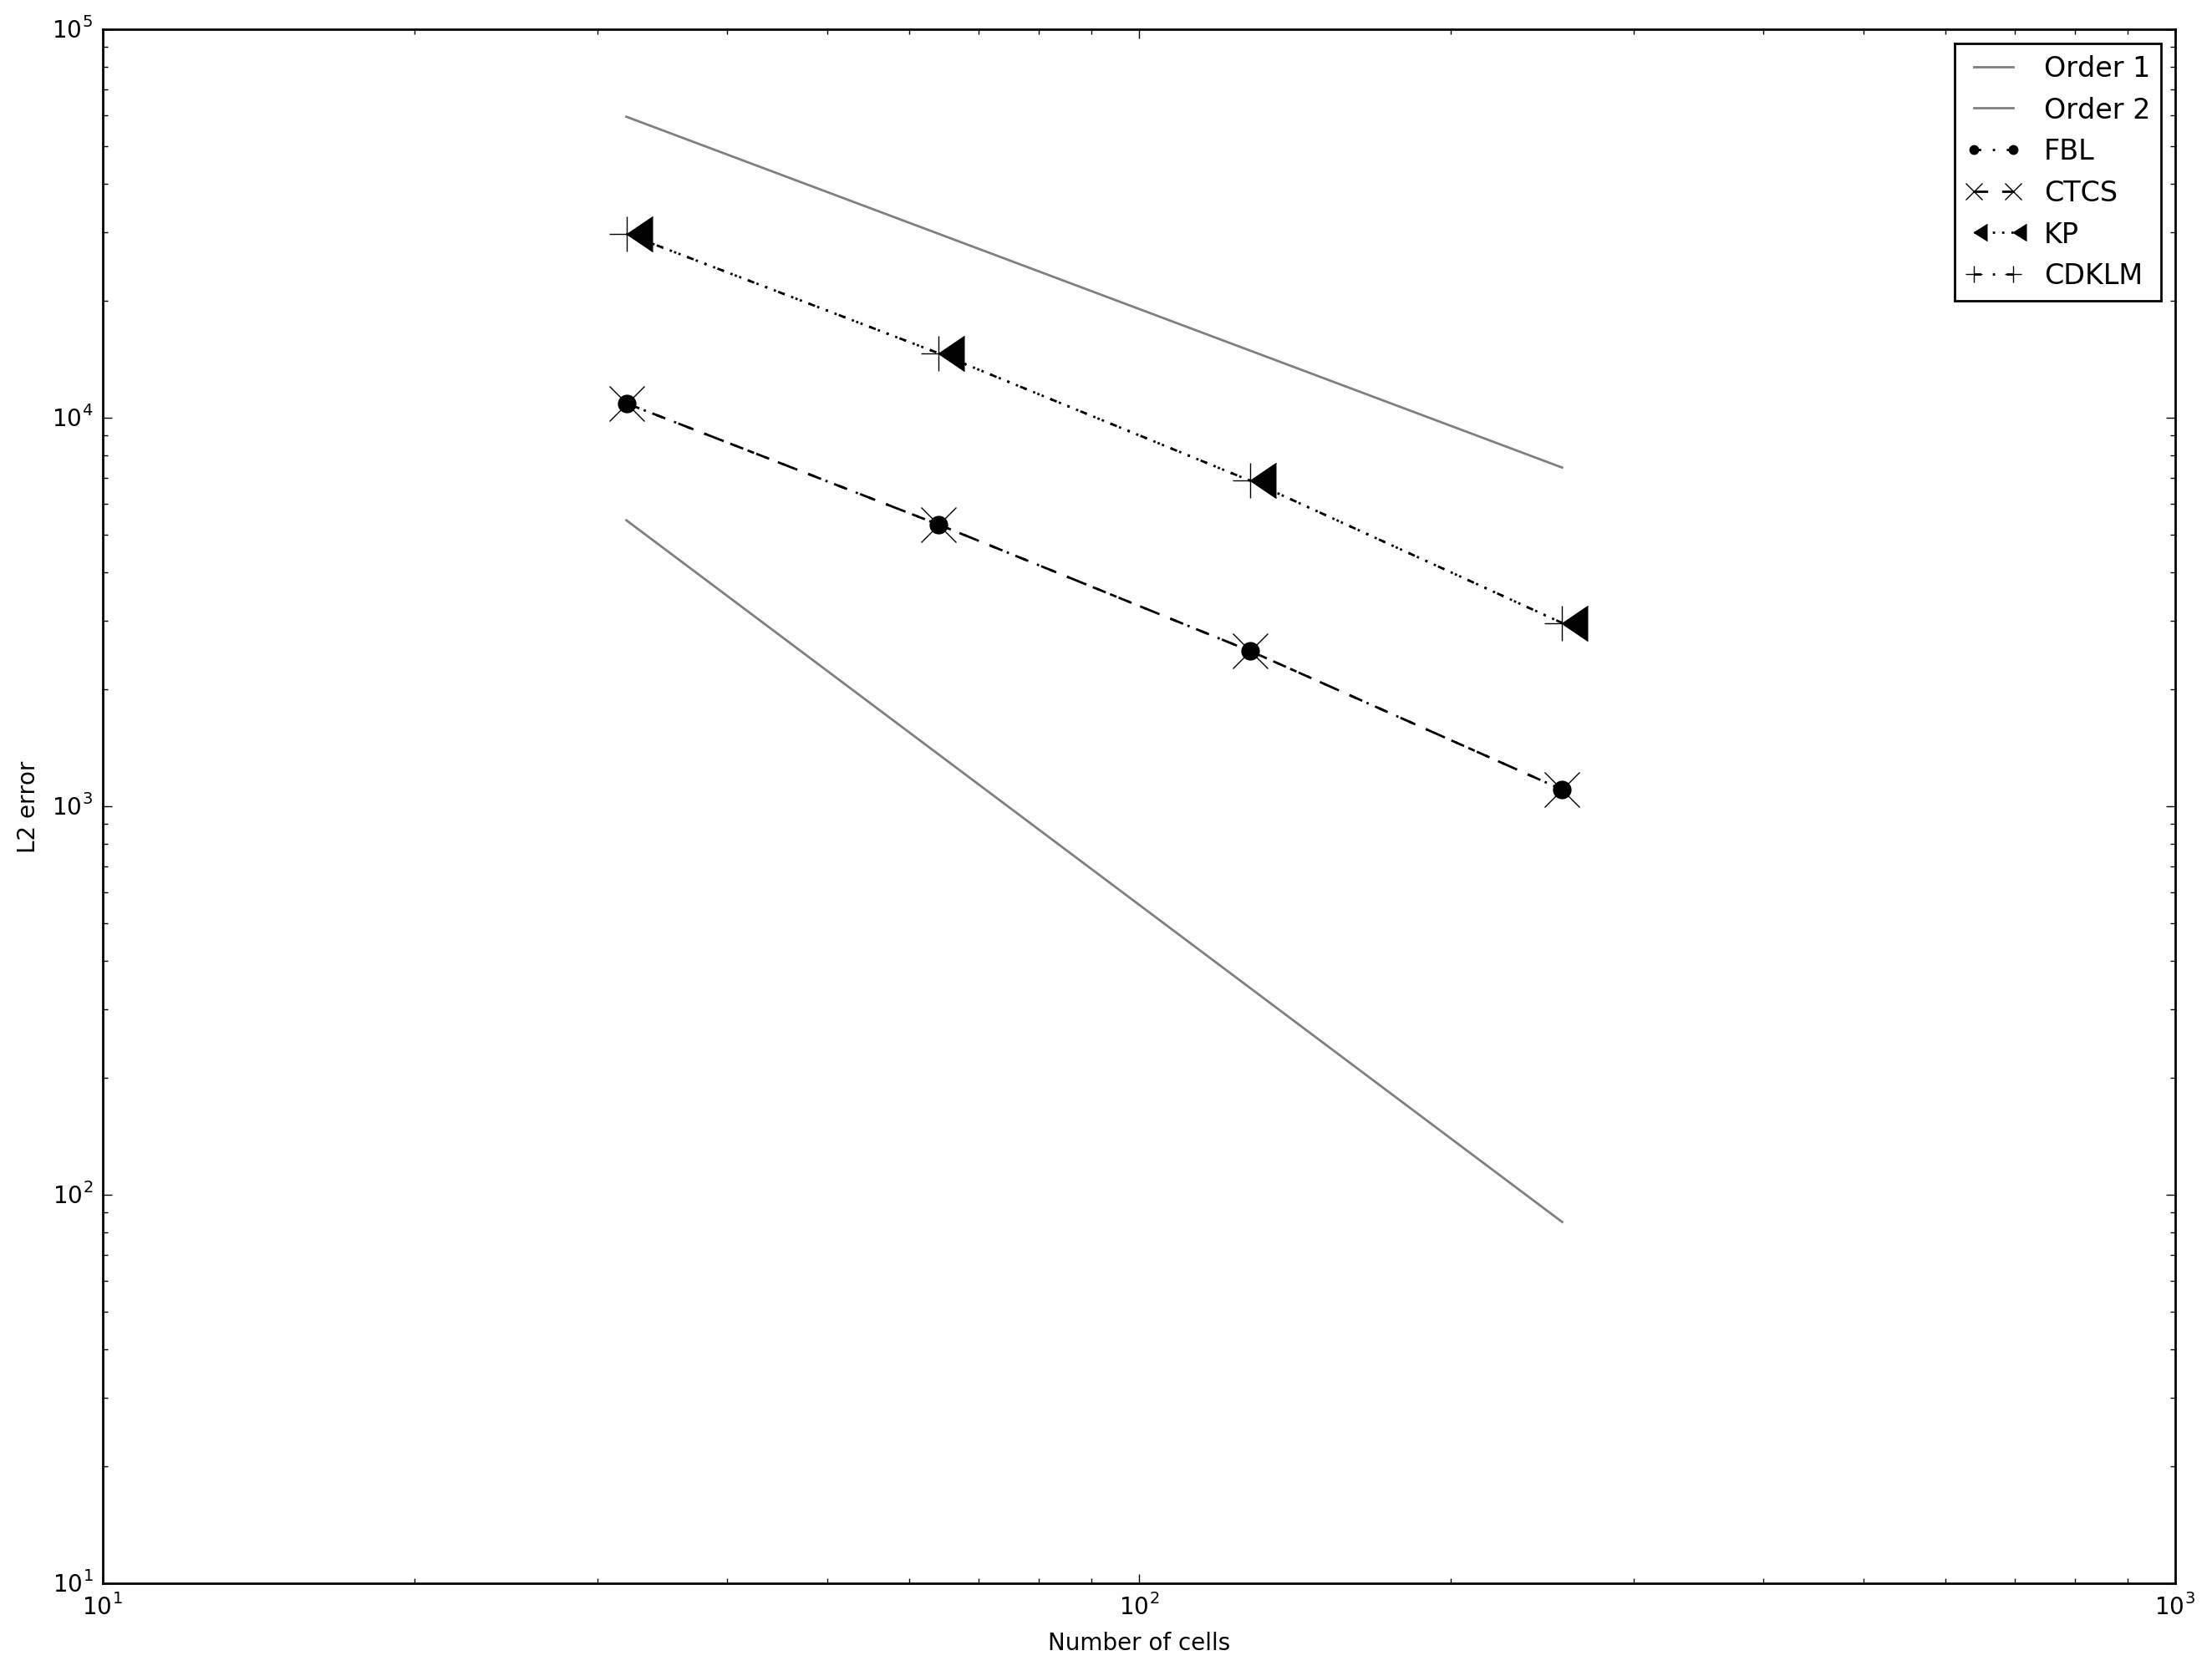

In [49]:
error = np.zeros([len(schemes), len(domain_sizes)])

for k, scheme in enumerate(schemes):
    print "Scheme: " + scheme
    
    in_filename = imgdir + "/" + scheme + "_data.npz"
    npzfile = np.load(in_filename)
    
    #Get reference
    eta1_ref = npzfile[str(reference_domain_size)]
    
    # Run all domain sizes
    for l, domain_size in enumerate(domain_sizes):
        eta1 = npzfile[str(domain_size)]

        #ver 1 : downsample til minste opplkøsning
        """
        eta1_ref_downsampled = rebin(eta1_ref, min(domain_sizes), min(domain_sizes))
        eta1_downsampled = rebin(eta1, min(domain_sizes), min(domain_sizes))
        tmp =eta1_ref_downsampled - eta1_downsampled
        error[k, l] = np.linalg.norm(tmp.flatten(), ord=2)
        """
        
        """
        #ver 2: downsample til current oppløsning
        eta1_ref_downsampled = rebin(eta1_ref, domain_size, domain_size)
        eta1_downsampled = eta1
        tmp =eta1_ref_downsampled - eta1_downsampled
        error[k, l] = np.linalg.norm(tmp.flatten(), ord=1) / (domain_size*domain_size)
        """
        
        #"""
        #ver 3: upsample til refereanseoppløsning
        eta1_ref_downsampled = eta1_ref
        upsampling = np.ones(np.divide(eta1_ref.shape, eta1.shape))
        eta1_downsampled = np.kron(eta1, upsampling)
        tmp =eta1_ref_downsampled - eta1_downsampled
        error[k, l] = np.linalg.norm(tmp.flatten(), ord=1)
        #"""
        
        
fig = plt.figure()
setBwStyles(fig.gca())

x = np.linspace(domain_sizes[0], domain_sizes[-1], 100);

#scaling = np.min(error[:,0]) * domain_sizes[0]**0.5 * 0.5
#plt.loglog(x, scaling/(np.sqrt(x)), '-', color='gray', label='Order 0.5')

scaling = np.max(error[:,0]) * domain_sizes[0] * 2
plt.loglog(x, scaling/x, '-', color='gray', label='Order 1')

scaling = np.min(error[:,0]) * domain_sizes[0]**2 * 0.5
plt.loglog(x, scaling/(x*x), '-', color='gray', label='Order 2')

for k in range(len(schemes)):
    print "Scheme " + str(schemes[k])
    for l in range(len(domain_sizes)):
        print "\tDomain size: " + str(domain_sizes[l]) + ": " + str(error[k,l])
    plt.loglog(domain_sizes, error[k,:], label=schemes[k], markersize=15)
#plt.loglog(domain_sizes, np.abs(error[0,:]-error[1,:]), label="Diff", markersize=15)
    
plt.xlabel('Number of cells')
plt.ylabel('L2 error')
plt.legend(markerscale=0.5)

In [ ]:
plt.imshow